In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1 - Exploratory Data Analysis

Using logins.json, which contains the timestamps of user logins, aggregate the login counts based on 15-minute time intervals and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them. 

**Result:**
- 0.94% (877 of 93142) of records are duplicates. Were removed
- No na values are present
- Two most prominent time-associated trends are found at the hourly level and at the day of the week level
    - At the Hourly level, demand is cyclic with a period of approximately 12 hours
        - Can be roughly described as 2 sub-cycles, one which peaks during the day and the other which peaks at night
            - Peaks are approximately at 12 pm and 10 pm
            - Night cycle is broader and appears to account for more logins than day cycle. Need to confirm
        - Outside of the to two sub-cycles, there are minor peaks at 5 am and 2 pm
        - Number of logins is at a minimum at 8 am
    - At the day of the week level, number of logins steadily increases from Monday-Saturday, then begins to drop on Sunday

In [2]:
logins = pd.read_json('logins.json')

In [3]:
logins.head(3)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37


In [4]:
print('number of null/na values: ', logins.isna().sum()[0])

number of null/na values:  0


In [5]:
print('number of logs: ', logins.shape[0])
print('number of duplicates: ', logins.shape[0] - len(logins.login_time.unique()))

number of logs:  93142
number of duplicates:  877


In [6]:
# removing duplicates
logins = logins.drop_duplicates()
# sorting in ascending order to simplify binning
logins = logins.sort_values(by='login_time')

In [7]:
# creating columns for aggregating
logins['login_day'] = logins['login_time'].dt.day
logins['login_dayofweek'] = logins['login_time'].dt.dayofweek
logins['login_month'] = logins['login_time'].dt.month
logins['login_intervals'] = logins['login_time'].dt.hour.astype(str) + ':' + (logins['login_time'].dt.minute//15*15).astype(str)
logins['login_intervals'].replace({':0$':':00'}, regex=True, inplace=True)

In [ ]:
counts = logins.groupby(['login_month', 'login_dayofweek', 'login_day', 'login_intervals']).count().reset_index()
counts.rename({'login_time':'login_counts'}, axis=1, inplace=True)

In [13]:
minute_counts = counts[['login_intervals', 'login_counts']].groupby(['login_intervals']).mean().reset_index()
minute_counts.rename({'login_counts':'mean_counts'}, axis=1, inplace=True)
minute_counts['std_counts'] = counts[['login_intervals', 'login_counts']].groupby(['login_intervals']).std().values
minute_counts['login_intervals'] = pd.to_datetime(minute_counts['login_intervals'], format='%H:%M').dt.time
minute_counts.sort_values(by='login_intervals', inplace=True)

my_df = counts[['login_month', 'login_day', 'login_counts']].groupby(['login_month', 'login_day']).sum().reset_index()
daily_counts = my_df[['login_day', 'login_counts']].groupby('login_day').mean().reset_index()
daily_counts.rename({'login_counts':'mean_counts'}, axis=1)
daily_counts['std_counts'] = my_df[['login_day', 'login_counts']].groupby('login_day').std().values

# dow = day of week
my_df = counts[['login_month', 'login_day', 'login_dayofweek', 'login_counts']].groupby(['login_month', 'login_day', 'login_dayofweek']).sum().reset_index()
dow_counts = my_df[['login_dayofweek', 'login_counts']].groupby('login_dayofweek').mean().reset_index()
dow_counts.rename({'login_counts':'mean_counts'}, axis=1)
dow_counts['std_counts'] = my_df[['login_dayofweek', 'login_counts']].groupby('login_dayofweek').std().values

month_counts = counts[['login_month', 'login_counts']].groupby('login_month').sum().reset_index()
month_counts.rename({'login_counts':'sum_counts'}, axis=1);

In [14]:
minute_counts.head(5)

,login_intervals,mean_counts,std_counts
0,00:00:00,13.931373,6.978411
1,00:15:00,14.990196,6.927482
2,00:30:00,14.843137,7.887507
3,00:45:00,14.411765,7.715682
44,01:00:00,14.950980,8.590090


In [15]:
daily_counts.head(3)

,login_day,login_counts,std_counts
0,1,791.50,483.511117
1,2,756.00,244.642596
2,3,859.75,436.692397


In [16]:
dow_counts.head(3)

,login_dayofweek,login_counts,std_counts
0,0,585.333333,117.730119
1,1,656.714286,197.658380
2,2,732.642857,185.957235


In [17]:
month_counts.head(3)

,login_month,login_counts
0,1,21103
1,2,24444
2,3,33376


In [22]:
my_df = counts
my_df['login_intervals'] = pd.to_datetime(counts['login_intervals'], format='%H:%M').dt.strftime('%H:%M')
my_df.sort_values(by='login_intervals', inplace=True)

In [25]:
plt.rcParams.update({'font.size': 14})

Text(0, 0.5, 'Number of Logins')

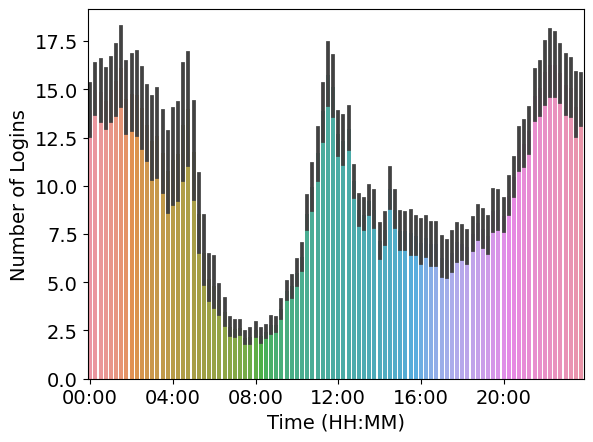

In [26]:
# Hourly Trend in Logins
sns.barplot(data=my_df, x='login_intervals', y='login_counts')
plt.xticks(np.arange(0,96,16))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Number of Logins')

Text(0, 0.5, 'Number of Logins')

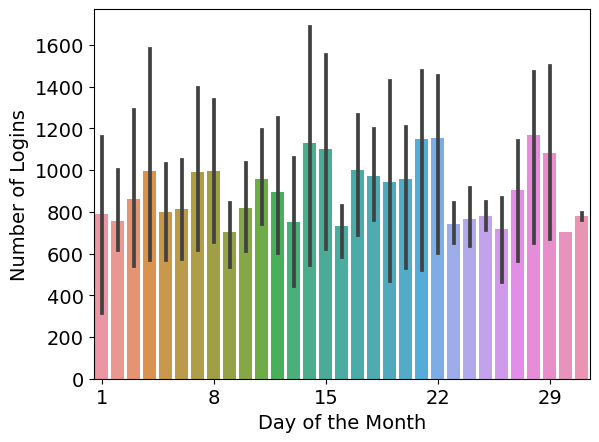

In [33]:
# Day of the Month Trend
sns.barplot(data=counts[['login_month', 'login_day', 'login_counts']].groupby(['login_month', 'login_day']).sum().reset_index(), x='login_day', y='login_counts')
plt.xticks(np.arange(0,29,7))
plt.xlabel('Day of the Month')
plt.ylabel('Number of Logins')

Text(0, 0.5, 'Number of Logins')

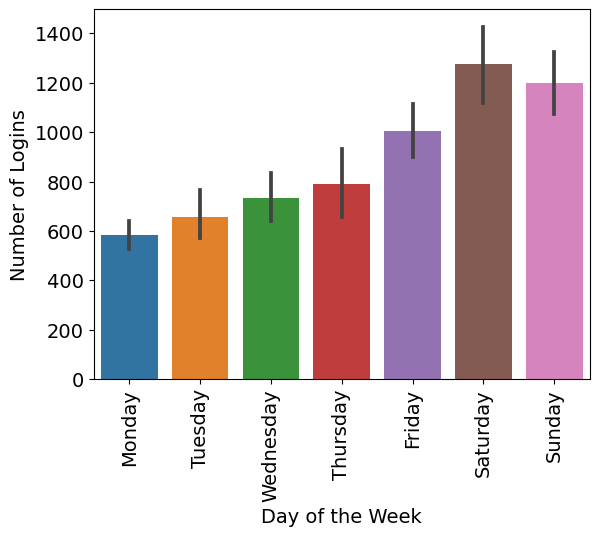

In [45]:
# Day of the Week Trend
my_df = counts[['login_month', 'login_day', 'login_dayofweek', 'login_counts']].groupby(['login_month', 'login_day', 'login_dayofweek']).sum().reset_index()
my_df.sort_values('login_dayofweek', inplace=True)
my_df['login_dayofweek'] = my_df['login_dayofweek'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})
sns.barplot(data=my_df, x='login_dayofweek', y='login_counts')
plt.xticks(rotation=90)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Logins')

Text(0, 0.5, 'Number of Logins')

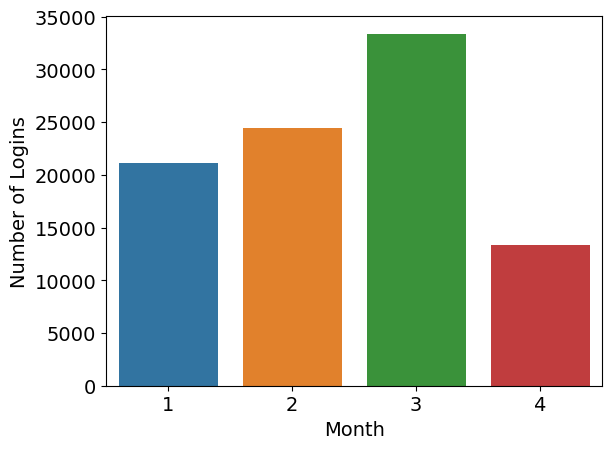

In [37]:
# Monthly Trend
sns.barplot(data=counts[['login_month', 'login_counts']].groupby('login_month').sum().reset_index(), x='login_month', y='login_counts')
plt.xlabel('Month')
plt.ylabel('Number of Logins')

## Part 2 - Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
    - **Answer: For the metric of success, I would choose the difference and p-value in the number of daily intercity trips completed. I would define intercity trips to be any driver partner trips in which a passenger requests to be driven from Gotham to Metropolis or vice-versa, as well as any instances in which a driver partner drives to Gotham from Metropolis or vice-versa in order to accept a new trip. Intercity trips directly measure a driver partner's availability in both cities. An increase in the number of intercity trips completed per day would suggest that driver partners are more available than before. Calculating a p-value will indicate whether an increase is statistically significant or not.**

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    a) how you will implement the experiment
    
    b) what statistical test(s) you will conduct to verify the significance of the observation
    
    c) how you would interpret the results and provide recommendations to the city operations team along with any caveats. 
    
    - **Answer: I would perform A/B testing to evaluate the efficacy of reimbursing toll costs. To perform A/B testing, I would choose a subset of available drivers for which all toll costs would be reimbursed. Then, I would calculate the number of daily intercity trips completed before reimbursement was made available and after, where I would define intercity trips to be any driver partner trips in which a passenger requests to be driven from Gotham to Metropolis or vice-versa, as well as any instances in which a driver partner drives to Gotham from Metropolis or vice-versa in order to accept a new trip. I would then calculate the change in daily intercity trips completed after reimbursement was made available. I would also calculate the same metrics for a control group for which reimbursement was not made available. By comparing the change in intercity trips for the group which was reimbursed (treated group) and the group which was not reimbursed (control), I can evaluate the effect of reimbursing toll costs on driver partner availability.**
    
        **Should the treated group show a statistically significant increase in intercity trips compared to the control group, then offering reimbursement very likely increases driver partner availability. I would then recommend to the Ultimate managers that toll costs be reimbursed although I would proceed with caution. Increasing availability may put more cars on the toll way and indirectly decrease availability. However, if the difference is not statistically significant, then offering reimbursement is not likely to increase driver availability. I would then recommend to the Ultimate managers that toll costs not be reimbursed because reimbursing tolls would cost the city money but would not yield the desired results.**

Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do not need this information to answer Part 2.


## Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
- **Answer: 24.4% of users were retained. Exploratory data analysis, visualizations, and insights can be found below in the corresponding section.**
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
- **Answer: I built a random forest classifier because the issue at hand is a classification problem and because exploratory data analysis indicates that active user trends non-linearly with the available features. An alternate approach could use logisitic regression, however, since the available features trend non-linearly with active user, a random forest model is likely to better identify active users. With a random forest classifier, we can predict with an accuracy of 0.77, a true positive rate of 0.523, and a true negative rate of 0.868, where the positive class is an active user and the negative class is a non-active user. Given a sample of 100 users, we would correctly identify 15 of the expected 28 active users and we would correctly identify 62 of the expect 72 non-active users. These results outperform a logistic regression model where the accuracy is 0.689, the true positive rate is 0.411, and the true negative rate is 0.867.**

    **By exploring feature importances through permuting individual features and calculating the impact on model accuracy, weekday activity, phone type, and average user rating were the three most impactful features to the random forest model. All three feature show a trend in active user, suggesting that the model is identifying real trends in the data. For the logistic regression model, however, average surge multiplier was the most impactful feature and average surge does not trend as strongly with active user, suggesting that the logistic regression model is not identifying as many real trends.**
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).
- **Answer: As exploratory data analysis shows and feature importance of the random forest classifier validated, users that request rides throughout the week, both on weekdays and on weekends, are more likely to be active users. Ultimate can leverage this insight by encouraging users to request rides throughout the week by offering conditional promotions. One way to implement such a conditional promotion is to issue a discount that is valid for only 3 days if the user has not requested a ride in the last 7 days. Therefore if a user last requested a ride the previous weekend, they would be encouraged to request a ride in the upcoming weekdays. By encouraging users to request rides more consistently, Ultimate may be able to improve long term rider retention.**

Data description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

Approach: 
1) User is active if last_trip_date is at least 5 months (150 days) after their signup_date
    - 24.4% of users are considered active
2) ```avg_rating_of_driver, phone, avg_rating_by_driver``` contain nan values
    - 16.2% (8122/50000) of ```avg_rating_of_driver``` - filled with knn in later step
    - 0.792% (396/50000) of ```phone``` - filled with knn in later step
    - 0.402% (201/50000) of ```avg_rating_by_driver``` - filled with knn in later step
3) Plotted histograms of ```city, trips_in_first_30_days, avg_rating_of_driver, avg_surge, phone, surge_pct, ultimate_black_user, weekday_pct, avg_dist, avg_rating_by_driver```
    - ```trips_in_first_30_days, avg_surge, surge_pct, avg_dist``` capped using 1.5*IQR
    - Although ```avg_rating_of_driver, avg_rating_by_drive``` between active users and non-active users are distributed slightly differently, may not be meaningful
    - ```city, phone, ultimate_black_user``` are likely to predict ```active_user```

In [2]:
df = pd.read_json('ultimate_data_challenge.json')
df['active_user'] = ((pd.to_datetime(df['last_trip_date']) - pd.to_datetime(df['signup_date'])).dt.days > 150).astype(int)
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

In [3]:
df.head(5)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0


In [4]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
active_user                  0
dtype: int64

In [5]:
df.shape

(50000, 13)

In [6]:
print('percent of active users: ', sum(df['active_user'])/df.shape[0])

percent of active users:  0.24396


In [7]:
df['phone'].describe()

count      49604
unique         2
top       iPhone
freq       34582
Name: phone, dtype: object

In [9]:
plt.rcParams.update({'font.size': 14})

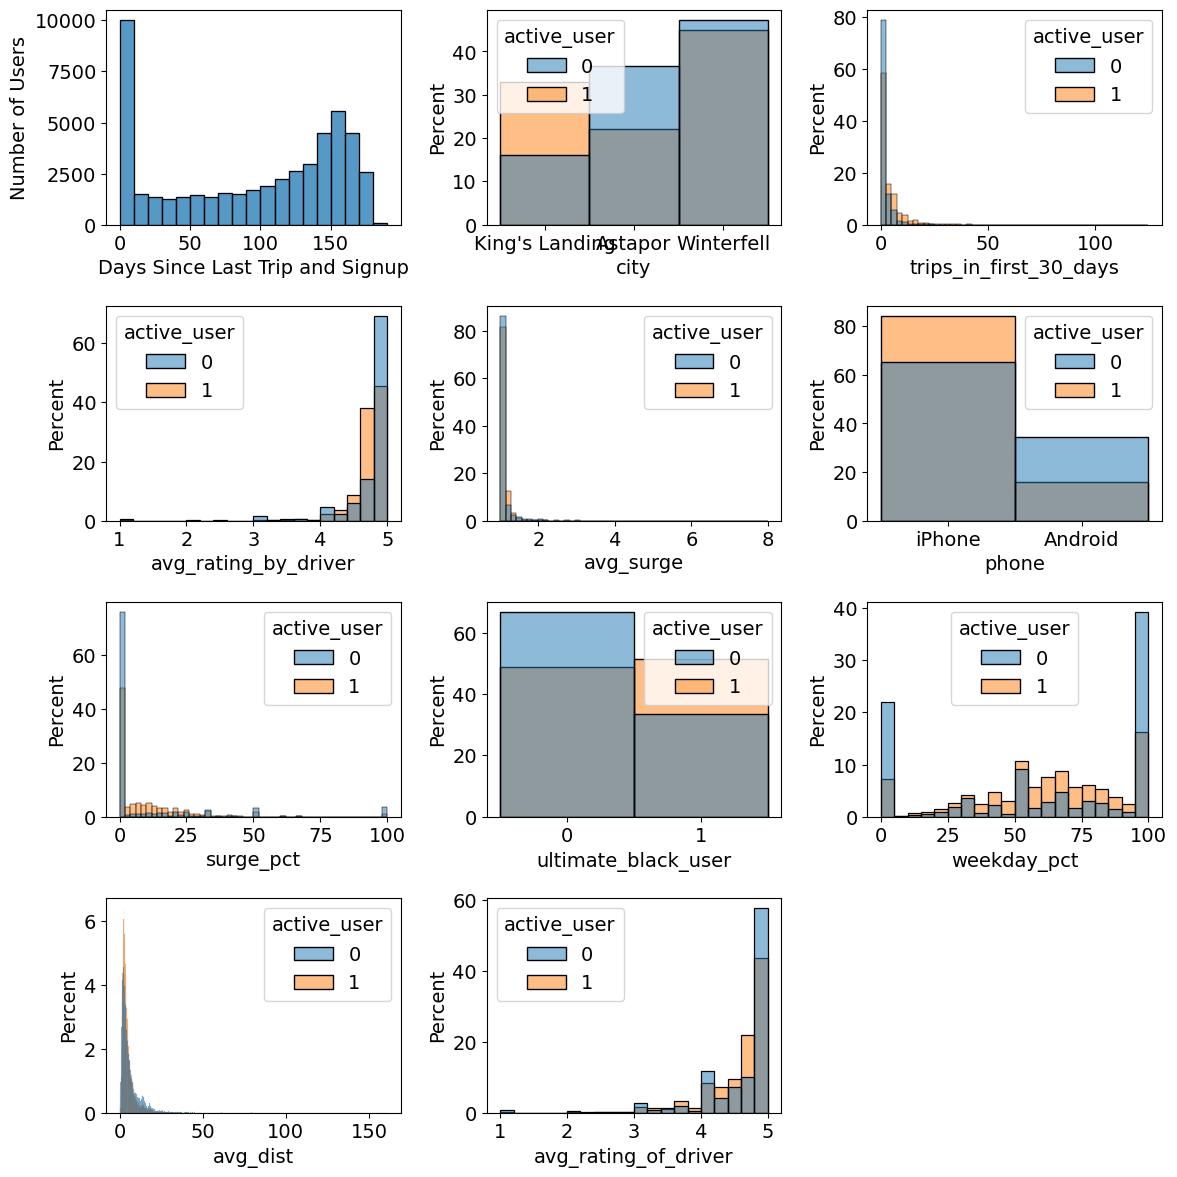

In [10]:
plt.figure(figsize=(12,12))
plt.subplot(4,3,1)
sns.histplot((pd.to_datetime(df['last_trip_date']) - pd.to_datetime(df['signup_date'])).dt.days, binwidth=10)
plt.xlabel('Days Since Last Trip and Signup')
plt.ylabel('Number of Users')
plt.subplot(4,3,2)
sns.histplot(data=df, x='city', hue='active_user', stat='percent', common_norm=False)
plt.subplot(4,3,3)
sns.histplot(data=df, x='trips_in_first_30_days', hue='active_user', common_norm=False, stat='percent', bins=50)
plt.subplot(4,3,4)
sns.histplot(data=df, x='avg_rating_by_driver', hue='active_user', stat='percent', bins=20, common_norm=False)
plt.subplot(4,3,5)
sns.histplot(data=df, x='avg_surge', hue='active_user', stat='percent', common_norm=False, bins=50)
plt.subplot(4,3,6)
sns.histplot(data=df, x='phone', hue='active_user', stat='percent', common_norm=False)
plt.subplot(4,3,7)
sns.histplot(data=df, x='surge_pct', hue='active_user', stat='percent', common_norm=False, bins=50)
plt.subplot(4,3,8)
sns.histplot(data=df, x='ultimate_black_user', hue='active_user', stat='percent', common_norm=False, bins=[-0.5, 0.5, 1.5])
plt.xticks([0,1])
plt.subplot(4,3,9)
sns.histplot(data=df, x='weekday_pct', hue='active_user', stat='percent', common_norm=False, bins=20)
plt.subplot(4,3,10)
sns.histplot(data=df, x='avg_dist', hue='active_user', stat='percent', common_norm=False)
plt.subplot(4,3,11)
sns.histplot(data=df, x='avg_rating_of_driver', hue='active_user', stat='percent', common_norm=False, bins=20)
plt.tight_layout()

#### Capping ```trips_in_first_30_days, avg_surge, surge_pct, avg_dist```

trips_in_first_30_days
Lower Whisker:  0.0
Upper Whisker:  7.0
avg_surge
Lower Whisker:  1.0
Upper Whisker:  1.12
surge_pct
Lower Whisker:  0.0
Upper Whisker:  21.5
avg_dist
Lower Whisker:  0.0
Upper Whisker:  13.72


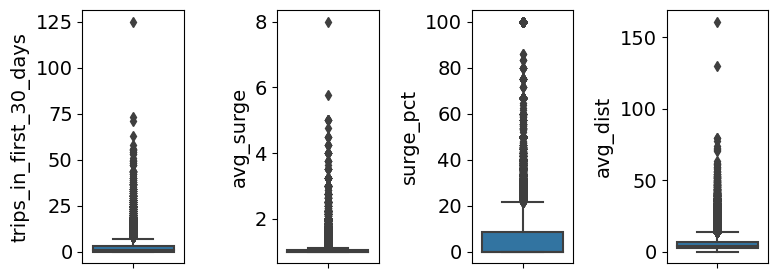

In [11]:
plt.figure(figsize=(8,3))
plt.subplot(1,4,1)
ax = sns.boxplot(data=df, y='trips_in_first_30_days')
lower_whisker = ax.lines[0].get_ydata()[1]
upper_whisker = ax.lines[1].get_ydata()[1]
print('trips_in_first_30_days')
print('Lower Whisker: ', lower_whisker)
print('Upper Whisker: ', upper_whisker)
plt.subplot(1,4,2)
ax = sns.boxplot(data=df, y='avg_surge')
lower_whisker = ax.lines[0].get_ydata()[1]
upper_whisker = ax.lines[1].get_ydata()[1]
print('avg_surge')
print('Lower Whisker: ', lower_whisker)
print('Upper Whisker: ', upper_whisker)
plt.subplot(1,4,3)
ax = sns.boxplot(data=df, y='surge_pct')
lower_whisker = ax.lines[0].get_ydata()[1]
upper_whisker = ax.lines[1].get_ydata()[1]
print('surge_pct')
print('Lower Whisker: ', lower_whisker)
print('Upper Whisker: ', upper_whisker)
plt.subplot(1,4,4)
ax = sns.boxplot(data=df, y='avg_dist')
lower_whisker = ax.lines[0].get_ydata()[1]
upper_whisker = ax.lines[1].get_ydata()[1]
print('avg_dist')
print('Lower Whisker: ', lower_whisker)
print('Upper Whisker: ', upper_whisker)
plt.tight_layout()

In [12]:
# capping trips_in_first_30_days, avg_surge, surge_pct, avg_dist using upper whisker
df['trips_in_first_30_days'].where(df['trips_in_first_30_days']<8, other=7, inplace=True)
df['avg_surge'].where(df['avg_surge']<1.12, other=1.12, inplace=True)
df['surge_pct'].where(df['surge_pct']<21.5, other=21.5, inplace=True)
df['avg_dist'].where(df['avg_dist']<13.72, other=13.72, inplace=True)

### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

I built a random forest classifier because the issue at hand is a classification problem and because exploratory data analysis indicates that active user trends non-linearly with the available features. An alternate approach could use logisitic regression, however, since the available features trend non-linearly with active user, a random forest model is likely to better identify active users. With a random forest classifier, we can predict with an accuracy of 0.77, a true positive rate of 0.523, and a true negative rate of 0.868, where the positive class is an active user and the negative class is a non-active user. Given a sample of 100 users, we would correctly identify 15 of the expected 28 active users and we would correctly identify 62 of the expect 72 non-active users. These results outperform a logistic regression model where the accuracy is 0.689, the true positive rate is 0.411, and the true negative rate is 0.867.

By exploring feature importances through permuting individual features and calculating the impact on model accuracy, weekday activity, phone type, and average user rating were the three most impactful features to the random forest model. All three feature show a trend in active user, suggesting that the model is identifying real trends in the data. For the logistic regression model, however, average surge multiplier was the most impactful feature and average surge does not trend as strongly with active user, suggesting that the logistic regression model is not identifying as many real trends. 

In [48]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

In [33]:
class OneHotNan(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        ohe = OneHotEncoder(sparse_output=False)
        X_oh = ohe.fit_transform(X)
        
        if True not in pd.isnull(ohe.categories_):
            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
        if True in pd.isnull(ohe.categories_):
            for ind, val in enumerate(ohe.categories_[0]):
                if pd.isnull(val):
                    nan_col = ind
            nan_rows = [ind for ind, val in enumerate(X_oh[:, nan_col]) if val > 0]

            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
            X_oh.loc[nan_rows,:] = pd.NA
            X_oh = X_oh.drop(columns=ohe.categories_[0][nan_col])
        return X_oh

class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        OH_NaN = OneHotNan()

        X_cat = pd.DataFrame()
        for cat_col in self.columns:
            df = OH_NaN.fit_transform(X[[cat_col]])

            new_cols = [cat_col+'_'+str(s) for s in df.columns]
            X_cat = pd.concat([X_cat, df.rename(columns=dict(zip(df.columns, new_cols)))], axis=1)
        return X_cat
    
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns]

In [49]:
def preprocess(df):
    '''
    Preprocesses feature space using KNNImputer to handle NaNs followed by standardscaler
    Do not feed in target space
    '''
    feature_union = FeatureUnion([
        ('cat_trans', CategoricalTransformer(columns=['city'])),
        ('num_trans', NumericalTransformer(columns=['trips_in_first_30_days', 'avg_rating_of_driver', 'phone', 'avg_surge', 
                                                    'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']))
    ])
    impute_pipe = Pipeline([
        ('features', feature_union),
        ('imputer', KNNImputer()),
        ('scaler', StandardScaler())
    ])

    df_imputed = impute_pipe.fit_transform(df)
    
    return df_imputed, impute_pipe

In [43]:
df['phone'] = df['phone'].replace({'iPhone':1, 'Android':0})

#### Random Forest Classifier

**Result:**

Outperformed LogisticRegression with a 0.81 increase in accuracy.

Trained ```RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=400)``` and scored on accuracy
- TPR = 0.523 (vs. 0.244 for random guess)
- TNR = 0.868 (vs. 0.756 for random guess)
- Accuracy = 0.770
- ```weekday_pct, phone, avg_rating_by_driver``` most important features in descending order
    - had greatest impact on accuracy when scrambled

In [52]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='active_user'), df['active_user'], test_size=0.25)
x_train, processor = preprocess(x_train)
columns = np.append(processor['features']['cat_trans'].transform(x_test).columns, processor['features']['num_trans'].transform(x_test).columns)
x_test = processor.transform(x_test)

In [53]:
pd.DataFrame(x_train, columns=columns).head(3)

,city_Astapor,city_King's Landing,city_Winterfell,trips_in_first_30_days,avg_rating_of_driver,phone,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,1.425403,-0.502873,-0.938526,-0.409212,0.674840,0.656816,-0.605122,-0.604369,-0.774619,-1.637322,2.213019,-1.737817
1,1.425403,-0.502873,-0.938526,-0.884834,0.674840,-1.522497,1.930446,1.844861,-0.774619,-0.022314,-0.910568,-0.173788
2,-0.701556,1.988572,-0.938526,0.542031,-0.186962,0.656816,-0.605122,-0.604369,-0.774619,1.054358,0.064575,0.496510


In [62]:
rf_class = RandomForestClassifier(class_weight='balanced')
grid_params = {'n_estimators':[300, 400, 500], 
               'max_depth':[10, 15, 20]}
gridsearch_rf = GridSearchCV(rf_class, grid_params, scoring='accuracy', return_train_score=True, cv=5)

In [63]:
gridsearch_rf.fit(x_train, y_train)
print(gridsearch_rf.best_estimator_)
print(gridsearch_rf.best_score_)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=400)
0.7764800000000001


In [64]:
y_pred = gridsearch_rf.best_estimator_.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[7777 1688]
 [1184 1851]]


In [65]:
print('TPR: ', cm[1,1]/(cm[0,1]+cm[1,1]))
print('TNR: ', cm[0,0]/(cm[0,0]+cm[1,0]))
print('Accuracy: ', (cm[1,1]+cm[0,0])/sum(sum(cm)))

TPR:  0.523029104266742
TNR:  0.8678718892980695
Accuracy:  0.77024


Text(0, 0.5, 'Mean accuracy decrease')

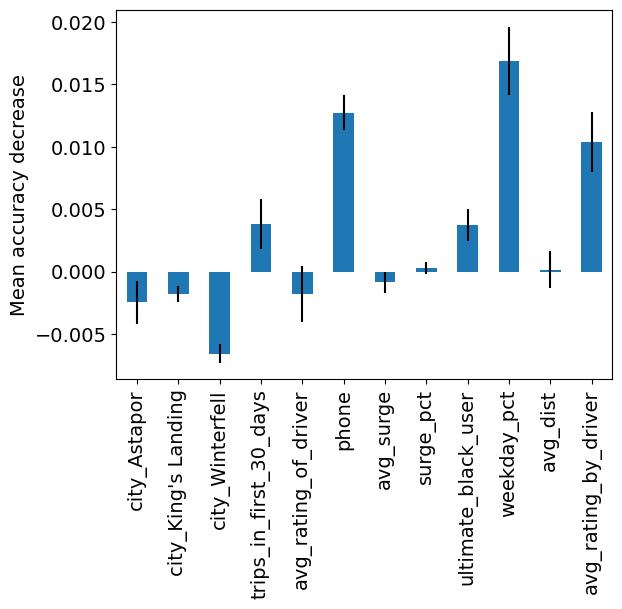

In [69]:
importances = permutation_importance(gridsearch_rf.best_estimator_, x_test, y_test, n_repeats=10)
forest_importances = pd.Series(importances.importances_mean, index=columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_ylabel("Mean accuracy decrease")

#### Logistic Regression

**Result:**

Trained ```LogisticRegression(class_weight='balanced', C=0.8)``` and scored on accuracy
- TPR = 0.411 (vs. 0.244 for random guess)
- TNR = 0.867 (vs. 0.756 for random guess)
- Accuracy = 0.689
- ```avg_surge``` most important feature
    - had greatest impact on accuracy when scrambled

In [77]:
df['active_user'].mean()

0.24396

In [70]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='active_user'), df['active_user'], test_size=0.25)
x_train, processor = preprocess(x_train)
columns = np.append(processor['features']['cat_trans'].transform(x_test).columns, processor['features']['num_trans'].transform(x_test).columns)
x_test = processor.transform(x_test)

In [71]:
pd.DataFrame(x_train, columns=columns).head(3)

,city_Astapor,city_King's Landing,city_Winterfell,trips_in_first_30_days,avg_rating_of_driver,phone,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,-0.698385,-0.504538,1.063506,2.436027,-1.374288,0.655735,0.661873,-0.165164,-0.777618,-0.392433,-0.219509,0.048412
1,-0.698385,-0.504538,1.063506,-0.412417,0.679314,0.655735,-0.605911,-0.604993,-0.777618,1.053920,0.192560,0.500364
2,-0.698385,1.982013,-0.940286,1.011805,0.679314,0.655735,-0.605911,-0.604993,1.285978,-0.969895,0.450755,0.500364


In [72]:
lr = LogisticRegression(class_weight='balanced')
grid_params = {'C':[0.6, 0.7, 0.8, 1, 1.5, 2]}
gridsearch_lr = GridSearchCV(lr, grid_params, scoring='accuracy')

In [73]:
gridsearch_lr.fit(x_train, y_train)
print(gridsearch_lr.best_estimator_)
print(gridsearch_lr.best_score_)

LogisticRegression(C=0.8, class_weight='balanced')
0.69024


In [74]:
y_pred = gridsearch_lr.best_estimator_.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[6592 2884]
 [1007 2017]]


In [75]:
print('TPR: ', cm[1,1]/(cm[0,1]+cm[1,1]))
print('TNR: ', cm[0,0]/(cm[0,0]+cm[1,0]))
print('Accuracy: ', (cm[1,1]+cm[0,0])/sum(sum(cm)))

TPR:  0.41154866353805347
TNR:  0.8674825634951967
Accuracy:  0.68872


Text(0, 0.5, 'Mean Accuracy Decrease')

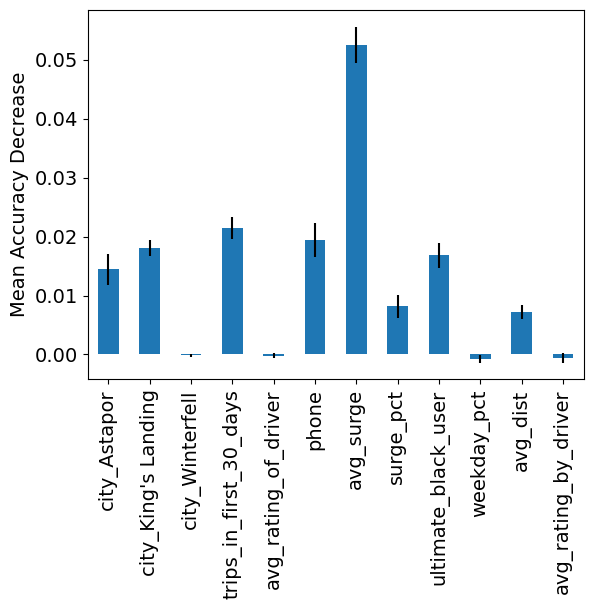

In [76]:
importances = permutation_importance(gridsearch_lr.best_estimator_, x_test, y_test, n_repeats=10)
lr_importances = pd.Series(importances.importances_mean, index=columns)
fig, ax = plt.subplots()
lr_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_ylabel("Mean Accuracy Decrease")

### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

As exploratory data analysis shows and feature importance of the random forest classifier validated, users that request rides throughout the week, both on weekdays and on weekends, are more likely to be active users. Ultimate can leverage this insight by encouraging users to request rides throughout the week by offering conditional promotions. One way to implement such a conditional promotion is to issue a discount that is valid for only 3 days if the user has not requested a ride in the last 7 days. Therefore if a user last requested a ride the previous weekend, they would be encouraged to request a ride in the upcoming weekdays. By encouraging users to request rides more consistently, Ultimate may be able to improve long term rider retention.